# Recover Current profiles from old Phase Diagram 

In [1]:
import sys
import os
sys.path.insert(0, '../magcolloids')

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import HTML, clear_output
import scipy.optimize as spo
import scipy.spatial as spa 
import magcolloids as mgc
import matplotlib as mpl
import string as st
import itertools as it

from tqdm.auto import tqdm

ureg = mgc.ureg

idx = pd.IndexSlice

%reload_ext autoreload
%autoreload 2

In [2]:
mpl.rc('text', usetex=True)
mpl.rcParams['figure.dpi'] = 150

In [3]:
directory = "/media/Antonio/Dynamic/DimerCurrents/FrequencySweeps/FrequencySweep_3.9/"
index = pd.read_csv(os.path.join(directory, "index.dat"), 
                    sep=" ", names = ["file", "h", "tilt"])

In [4]:
index.head()

,file,h,tilt
0,Tilt_2.0_deg_h3899_2019_09_25_17_17_30,3.9,2.0
1,Tilt_16.5_deg_h3899_2019_09_25_17_17_30,3.9,16.5
2,Tilt_4.5_deg_h3899_2019_09_25_17_17_30,3.9,4.5
3,Tilt_1.5_deg_h3899_2019_09_25_17_17_30,3.9,1.5
4,Tilt_14.0_deg_h3899_2019_09_25_17_17_30,3.9,14.0


In [5]:
diff_vel_pd = pd.read_csv(os.path.join(directory,"differentiated_velocities.dat"),
            sep = "\t", 
            index_col = [0,1,2])

diff_vel_pd["tilt"] = index.reindex(diff_vel_pd.index.get_level_values("file")).tilt.values

diff_vel_pd = diff_vel_pd.set_index("tilt",append=True).reorder_levels(
    ["file","tilt","frequency","plane"]).sort_index().droplevel(0)

diff_vel_pd.head()

x         y
tilt frequency plane                    
2.0  0.125     down   0.081304  0.136209
               up    -0.034048 -0.139723
     0.250     down  -0.172325 -0.191785
               up     0.151873  0.180083
     0.375     down  -0.142345  0.311106

In [6]:
diff_vel_pd["z"] = np.NaN
diff_vel_pd.loc[diff_vel_pd.query("plane=='up'").index,"z"]=1
diff_vel_pd.loc[diff_vel_pd.query("plane=='down'").index,"z"]=-1

In [7]:
d = 2.8
phi = 0.2625

factor = d*np.sqrt(np.pi/np.sqrt(3)/phi)

The factor of two below comes from the fact that each value of current only measures the current of the upper or lower plane. 

In [8]:
diff_vel_pd["I"] = 2*np.sqrt(
    (diff_vel_pd.x*diff_vel_pd.z)**2 + 
    (diff_vel_pd.y*diff_vel_pd.z)**2)/(factor*diff_vel_pd.index.get_level_values("frequency"))

current = diff_vel_pd.groupby(["tilt","frequency"]).I.mean()

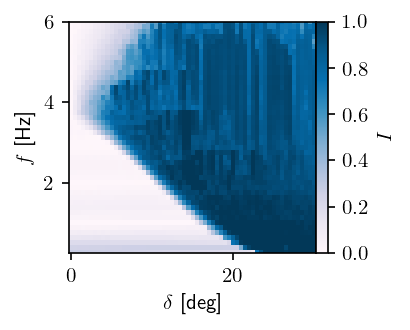

In [9]:
current_mat = current.unstack()
tilt = current_mat.index.get_level_values("tilt")
freq = current_mat.columns.get_level_values("frequency")

fig = plt.figure(figsize=(2.5,2))
cm = plt.pcolormesh(tilt,freq,current_mat.transpose(),cmap="PuBu")

plt.xlabel(r"$\delta$ [deg]")
plt.ylabel("$f$ [Hz]")
plt.ylim(0.25,6)

plt.clim(0,1)
axcb = fig.colorbar(cm, pad=0)
axcb.set_label(r'$I$')

## Plot of current vs $f$ for some tilts $\delta$ 

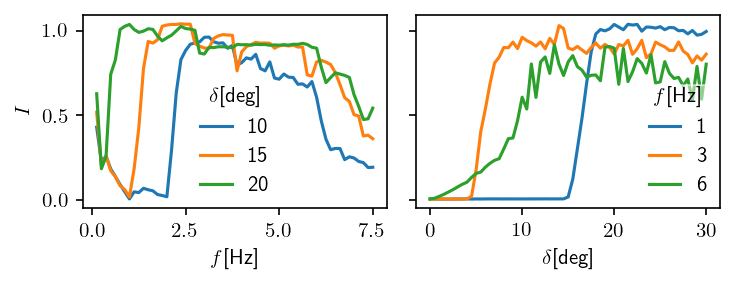

In [10]:
fig, ax = plt.subplots(1,2,figsize=(5,2), sharey=True, tight_layout=True)

for i in [10,15,20]:
    ax[0].plot(current.loc[i], label=i)


for f in [1,3,6]:
    ax[1].plot(current.reorder_levels(["frequency","tilt"]).loc[f], label = f)
    

ax[0].set_ylabel("$I$")
ax[0].set_xlabel("$f$[Hz]")
ax[1].set_xlabel("$\delta$[deg]")

ax[0].legend(
    title = "$\delta$[deg]",
    borderpad = 0.1,
    fancybox = False,
    edgecolor = "w",
    framealpha = 0.5,
    handlelength = 1.5,
    loc = 8
            )

ax[1].legend(
    title = "$f$[Hz]",
    borderpad = 0.1,
    fancybox = False,
    edgecolor = "w",
    framealpha = 0.5,
    handlelength = 1.5,
    loc = 4
            )

In [11]:
current.loc[[10,15,20]].unstack().transpose().to_csv(
    "../Plots/current_vs_freq.dat", sep = "\t")
current.reorder_levels(["frequency","tilt"]
                      ).loc[[1,3,6]].unstack().transpose().to_csv(
    "../Plots/current_vs_tilt.dat", sep = "\t")